In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from tintx import RunDirectory, config

**Create some synthetic data**

We'll use a Gaussian that's translated at a constant speed

In [2]:
t = np.arange(0, 100)
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)

[T, X, Y] = np.meshgrid(t, x, y, indexing='ij')

Z = np.exp(-(X-(0.02*T)+1)**2 * 10) * np.exp(-Y**2*10)

**Convert to a DataArray object**

In [3]:
times = pd.date_range(start='2020-01-01', periods=100, freq='1H')
Z_xr = xr.DataArray(Z, coords={'time': times, 'lon': x, 'lat': y})

**Run the tracking algorithm**

In [4]:
run_dir = RunDirectory(Z_xr, 'mask')
num_cells = run_dir.get_tracks(min_size=10, field_thresh=0.5)
run_dir.tracks

Tracking:   0%|          | 0/99 [00:00<?, ?it/s]

,,time,grid_x,grid_y,lon,lat,area,max,mean,isolated,geometry
scan,uid,,,,,,,,,,
0,0,2020-01-01 00:00:00,24.5,2.514,-0.0204,-0.8776,70,0.995844,0.735281,False,"POLYGON ((-0.22449 -1.00000, -0.22449 -0.83673..."
1,0,2020-01-01 01:00:00,24.5,2.676,-0.0204,-0.8776,74,0.991868,0.747985,False,"POLYGON ((-0.22449 -1.00000, -0.22449 -0.83673..."
2,0,2020-01-01 02:00:00,24.5,3.000,-0.0204,-0.8776,82,0.995837,0.746571,False,"POLYGON ((-0.22449 -1.00000, -0.22449 -0.79592..."
3,0,2020-01-01 03:00:00,24.5,3.163,-0.0204,-0.8776,86,0.992186,0.754781,False,"POLYGON ((-0.22449 -1.00000, -0.22449 -0.79592..."
4,0,2020-01-01 04:00:00,24.5,3.489,-0.0204,-0.8776,94,0.995817,0.750140,False,"POLYGON ((-0.22449 -1.00000, -0.22449 -0.75510..."
...,...,...,...,...,...,...,...,...,...,...,...
95,0,2020-01-04 23:00:00,24.5,45.347,-0.0204,0.8367,98,0.992490,0.753908,False,"POLYGON ((-1.00000 -1.00000, -1.00000 1.04082,..."
96,0,2020-01-05 00:00:00,24.5,45.511,-0.0204,0.8776,94,0.995817,0.750140,False,"POLYGON ((-1.00000 -1.00000, -1.00000 1.04082,..."
97,0,2020-01-05 01:00:00,24.5,45.837,-0.0204,0.8776,86,0.992186,0.754781,False,"POLYGON ((-1.00000 -1.00000, -1.00000 1.04082,..."


**Create an animation of the tracking**

The object centroid is the dot, and the polygon is outlined & shaded.

CPU times: user 13.4 s, sys: 299 ms, total: 13.7 s
Wall time: 14.5 s


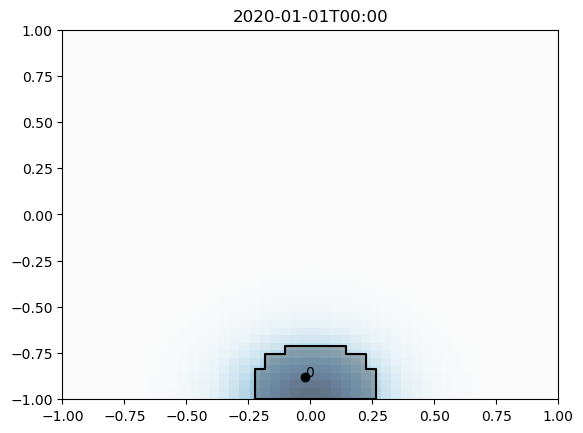

In [5]:
%%time

fig = plt.figure()

time_format = str(Z_xr.isel(time=0).time.values)[:16]

[lons, lats] = np.meshgrid(Z_xr['lon'], Z_xr['lat'])

plt.pcolormesh(lons, lats, Z_xr.isel(time=0), vmin=-1, vmax=1, cmap='RdBu', alpha=0.5)
plt.title(f'{time_format}')
plt.xlim((-1, 1))
plt.ylim((-1, 1))

def plot_geom(run_dir, geom_t, t):
    for i, geom_x in enumerate(geom_t):
        x, y = geom_x.exterior.xy
        x, y = np.array(x), np.array(y)
        uid = int(geom_t.index[i])
        ln = plt.plot(x, y, color='k')
        plt.fill(x, y, alpha=0.25, color='k')
        lon, lat = run_dir.tracks.lon.xs(t+1, level='scan')[i], run_dir.tracks.lat.xs(t+1, level='scan')[i]
        plt.scatter(lon, lat, color='k')
        plt.text(lon, lat, uid)

        
geom_t = run_dir.tracks.geometry.xs(1, level='scan')
plot_geom(run_dir, geom_t, 0)

def animate(t):
    #print(t)
    
    plt.clf()
    plt.pcolormesh(lons, lats, Z_xr.isel(time=t), vmin=-1, vmax=1, cmap='RdBu', alpha=0.5)
    
    geom_t = run_dir.tracks.geometry.xs(t+1, level='scan')
    plot_geom(run_dir, geom_t, t)
    time_format = str(Z_xr.isel(time=t).time.values)[:16]
    plt.title(f'{time_format}')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))

    
outpath = f'test_tintx_animation.mp4'

anim = manim.FuncAnimation(fig, animate, frames=run_dir.time.size -1, interval=50)
anim.save(outpath, dpi=200, bitrate=-1, fps=10)

Below we can see that the issue occurs from time 93 to time 94:

In [6]:
run_dir.tracks['geometry'][93]

uid
0    POLYGON ((-0.10204 0.63265, 0.14286 0.63265, 0...
Name: geometry, dtype: geometry

<Axes: >

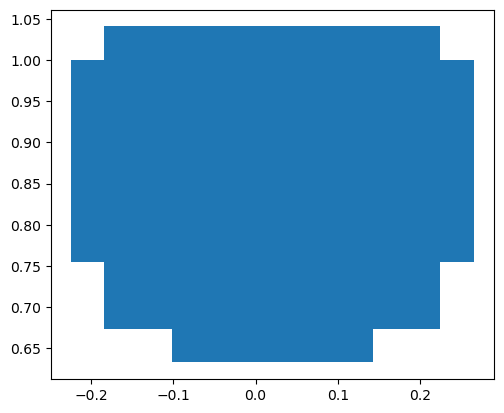

In [7]:
run_dir.tracks['geometry'][93].plot()

In [8]:
run_dir.tracks['geometry'][94]

uid
0    POLYGON ((-1.00000 -1.00000, -1.00000 1.04082,...
Name: geometry, dtype: geometry

<Axes: >

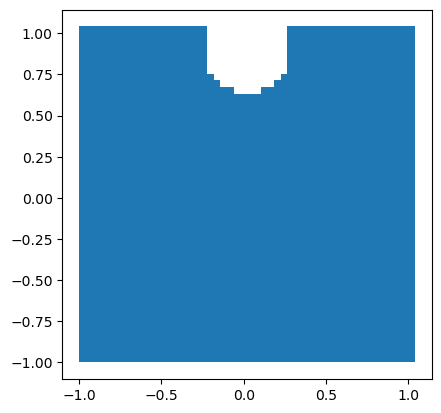

In [9]:
run_dir.tracks['geometry'][94].plot()